<a href="https://colab.research.google.com/github/vimalkaur81/END-2.0-Assignments/blob/main/Sentiment_Analysis_using_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 TorchText

## Dataset Preview

Your first step to deep learning in NLP. We will be mostly using PyTorch. Just like torchvision, PyTorch provides an official library, torchtext, for handling text-processing pipelines. 

We will be using previous session tweet dataset. Let's just preview the dataset.

In [12]:
!pip install pytreebank

In [6]:
import pytreebank
import sys
import os

out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst()
# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))
# Print the length of the training set
print(len(dataset['train']))

8544


In [56]:
import pandas as pd
# Read train data
df_train = pd.read_csv('sst_train.txt', sep='\t', header=None, names=['label', 'text'])
df_train['label'] = df_train['label'].str.replace('__label__', '')
df_train['label'] = df_train['label'].astype(int).astype('category')

df_dev = pd.read_csv('sst_dev.txt', sep='\t', header=None, names=['label', 'text'])
df_dev['label'] = df_dev['label'].str.replace('__label__', '')
df_dev['label'] = df_dev['label'].astype(int).astype('category')

df_test = pd.read_csv('sst_test.txt', sep='\t', header=None, names=['label', 'text'])
df_test['label'] = df_test['label'].str.replace('__label__', '')
df_test['label'] = df_test['label'].astype(int).astype('category')

In [75]:
df_train['len'] = df_train['text'].str.len()  # Store string length of each sample
df_train = df_train.sort_values(['len'], ascending=True)
df_train.head(10)

,label,text,len
593,3,Go .,4
8484,3,Eh .,4
4198,4,Wow .,5
5286,4,Yes .,5
5288,2,No. .,5
1270,2,Why ?,5
335,4,Cool .,6
2038,3,A. . .,6
7670,4,Zoom !,6
7669,3,Bang !,6


Text(0, 0.5, 'Label')

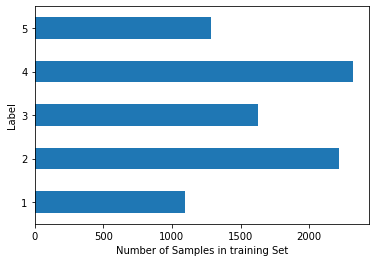

In [59]:
import matplotlib.pyplot as plt

ax = df_train['label'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

Text(0, 0.5, 'Label')

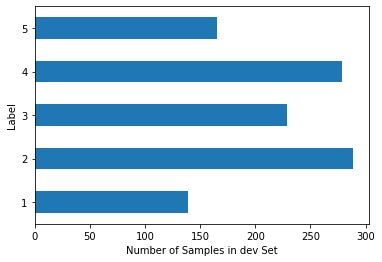

In [60]:
ax = df_dev['label'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in dev Set")
ax.set_ylabel("Label")

Text(0, 0.5, 'Label')

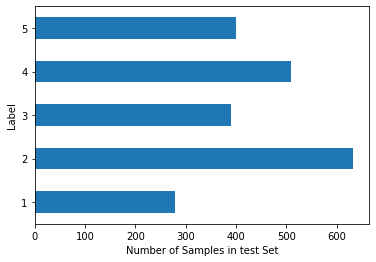

In [61]:
ax = df_test['label'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in test Set")
ax.set_ylabel("Label")

## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [62]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [63]:
text = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [64]:
fields = [('Text', text),('Label',label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [65]:
example_train = [data.Example.fromlist([df_train.text[i],df_train.label[i]], fields) for i in range(df_train.shape[0])] 

In [103]:
[df_train.text[0],df_train.label[0]]

["The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",
 4]

In [66]:
example_dev = [data.Example.fromlist([df_dev.text[i],df_dev.label[i]], fields) for i in range(df_dev.shape[0])] 

In [67]:
example_test = [data.Example.fromlist([df_test.text[i],df_test.label[i]], fields) for i in range(df_test.shape[0])] 

In [104]:
# Creating dataset

train = data.Dataset(example_train, fields)
valid = data.Dataset(example_dev, fields)
test = data.Dataset(example_test, fields)

Finally, we can split into training, testing, and validation sets by using the split() method:

In [105]:
(len(train), len(valid))

(8544, 1101)

An example from the dataset:

In [106]:
type(train)

torchtext.legacy.data.dataset.Dataset

In [102]:
type(example_train)

list

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:


In [77]:
text.build_vocab(train)
label.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [79]:
print('Size of input vocab : ', len(text.vocab))
print('Size of label vocab : ', len(label.vocab))
print('Top 10 words appreared repeatedly :', list(text.vocab.freqs.most_common(10)))
print('Labels : ', label.vocab.stoi)

Size of input vocab :  17165
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 8041), (',', 7131), ('the', 6087), ('and', 4474), ('of', 4446), ('a', 4423), ('to', 3024), ('-', 2739), ("'s", 2544), ('is', 2540)]
Labels :  defaultdict(None, {4: 0, 2: 1, 3: 2, 5: 3, 1: 4})


**Lots of stopwords!!**

Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

But at first declare the device we are using.

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [107]:
train_iterator= data.BucketIterator(train,
                                       batch_size = 32, 
                                       sort_key = lambda x: len(x.Text),
                                       sort_within_batch=True, device = device)

valid_iterator= data.BucketIterator(valid,
                                       batch_size = 32, 
                                       sort_key = lambda x: len(x.Text),
                                       sort_within_batch=True, device = device)

Save the vocabulary for later use

In [82]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(text.vocab.stoi, tokens)

## Defining Our Model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [83]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [84]:
# Define hyperparameters
size_of_vocab = len(text.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [85]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(17165, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
The model has 5,391,403 trainable parameters


## Model Training and Evaluation

First define the optimizer and loss functions

In [109]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [112]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        #text, text_lengths = batch.text   
        
        # convert to 1D tensor
        #predictions = model(text, text_lengths).squeeze()  
        
        # compute the loss
        #loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        #loss.backward()       
        
        # update the weights
        #optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

In [111]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.text
            
            # convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.truth)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [113]:
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

NameError: ignored

## Model Testing

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [ ]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.")

'Negative'

## Discussion on Data Augmentation Techniques 

You might wonder exactly how you can augment text data. After all, you can’t really flip it horizontally as you can an image! :D 

In contrast to data augmentation in images, augmentation techniques on data is very specific to final product you are building. As its general usage on any type of textual data doesn't provides a significant performance boost, that's why unlike torchvision, torchtext doesn’t offer a augmentation pipeline. Due to powerful models as transformers, augmentation tecnhiques are not so preferred now-a-days. But its better to know about some techniques with text that will provide your model with a little more information for training. 

### Synonym Replacement

First, you could replace words in the sentence with synonyms, like so:

    The dog slept on the mat

could become

    The dog slept on the rug

Aside from the dog's insistence that a rug is much softer than a mat, the meaning of the sentence hasn’t changed. But mat and rug will be mapped to different indices in the vocabulary, so the model will learn that the two sentences map to the same label, and hopefully that there’s a connection between those two words, as everything else in the sentences is the same.

### Random Insertion
A random insertion technique looks at a sentence and then randomly inserts synonyms of existing non-stopwords into the sentence n times. Assuming you have a way of getting a synonym of a word and a way of eliminating stopwords (common words such as and, it, the, etc.), shown, but not implemented, in this function via get_synonyms() and get_stopwords(), an implementation of this would be as follows:


In [ ]:
def random_insertion(sentence, n): 
    words = remove_stopwords(sentence) 
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        sentence.insert(randrange(len(sentence)+1), new_synonym) 
    return sentence

## Random Deletion
As the name suggests, random deletion deletes words from a sentence. Given a probability parameter p, it will go through the sentence and decide whether to delete a word or not based on that random probability. Consider of it as pixel dropouts while treating images.

In [ ]:
def random_deletion(words, p=0.5): 
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining

### Random Swap
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.

In [ ]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

For more on this please go through this [paper](https://arxiv.org/pdf/1901.11196.pdf).

### Back Translation

Another popular approach for augmenting text datasets is back translation. This involves translating a sentence from our target language into one or more other languages and then translating all of them back to the original language. We can use the Python library googletrans for this purpose. 

In [ ]:
import random
import googletrans
import googletrans.Translator

translator = Translator()
sentence = ['']

available_langs = list(googletrans.LANGUAGES.keys()) 
trans_lang = random.choice(available_langs) 
print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

translations = translator.translate(sentence, dest=trans_lang) 
t_text = [t.text for t in translations]
print(t_text)

translations_en_random = translator.translate(t_text, src=trans_lang, dest='en') 
en_text = [t.text for t in translations_en_random]
print(en_text)